# Network Optimization 

We approach the problem of controlling the stormwater network in two ways. 
1. Centralized Controller Approach 
2. Decentralized Control Approach

## Virtual Tank Model 

This approach assumes a idealized version of the stormwater network, where each each pond is rectangular and channels that are moving the water are perfect with zero losses. 
![virtual tank](./vt.png)

**Assumptions**
1. Time of travel between tanks is assumed to be known. 
2. Water in the tanks travels in packets. 
3. Outflows from the ponds are just a function of the water level

## Centralized Control

In this setting, we have a centralized controller that monitors all the states in the network and decides on which action to take. 

**Terminology**
- $A$ links in the network
- $V_i^t$ volume in the $i^{th}$ tank at $t^{th}$ time
- $x_{ij}^t $ outflow from $i^{th}$ tank to $j^{th}$ at $t^{th}$ time
- $q_i^t$ inflow into $i^{th}$ tank at $t^{th}$ time
- $N$ is the number of tanks 
- $T$ time horizon for solving
- $u_{ij}$ is the upper bound for flow in link. 

***Objective Function***

If the objective is to minimize the utility in the tanks. 
$$ \min \sum^N_{i} \sum^T_t V_i^t $$

If the objective is to move water as fast as possible.
$$ \max \sum^N_{i} \sum^T_t x_{ij}^t $$
***Constraints***

_Mass Balance_:

This constraint accounts for the mass balance in the tanks. This constraint accounts for the time of travel between tanks($\delta_{ji}$). 

$$ V_i^t = V_i^{t-1} + q_i^{t-1} +  \sum_{j} x_{ji}^{t-\delta_{ji}} - \sum_{j} x_{ij}^{t-1}\ \text{for}\ \forall t\  \text{and}\ \forall i$$

_Flow thresholds_:
$$ x_{ij}^t \leq u_{ij}\ \text{for}\ \forall t\  \text{and}\ \forall ij \in A$$

_Outflow limitation_:

Amount of water that can be released from the tank at any time $t$ is limited by the volume in the tank. Though this relation is non-linear (i.e. $\sqrt{2*g*depth}$, we assume a linear relationship in this formulation.
$$ x_{ij}^t \leq f(V_{ij}^{t-1}) \ \text{for}\ \forall t\  \text{and}\ \forall ij \in A$$

#### Example : Controlling three ponds

![3ponds](./threeponds.png)

In [7]:
## Plotting Libraries 
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {}
import seaborn as sns
sns.set_style("whitegrid")
import copy 
import numpy as np
from gurobipy import *

Optimize a model with 3147 rows, 2100 columns and 6966 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+03, 1e+03]
  RHS range        [2e+00, 1e+03]
Presolve removed 1743 rows and 568 columns
Presolve time: 0.01s
Presolved: 1404 rows, 1532 columns, 4846 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5259936e+04   5.702711e+04   0.000000e+00      0s
    1043    5.0400000e+03   0.000000e+00   0.000000e+00      0s

Solved in 1043 iterations and 0.12 seconds
Optimal objective  5.040000000e+03


<IPython.core.display.Javascript object>


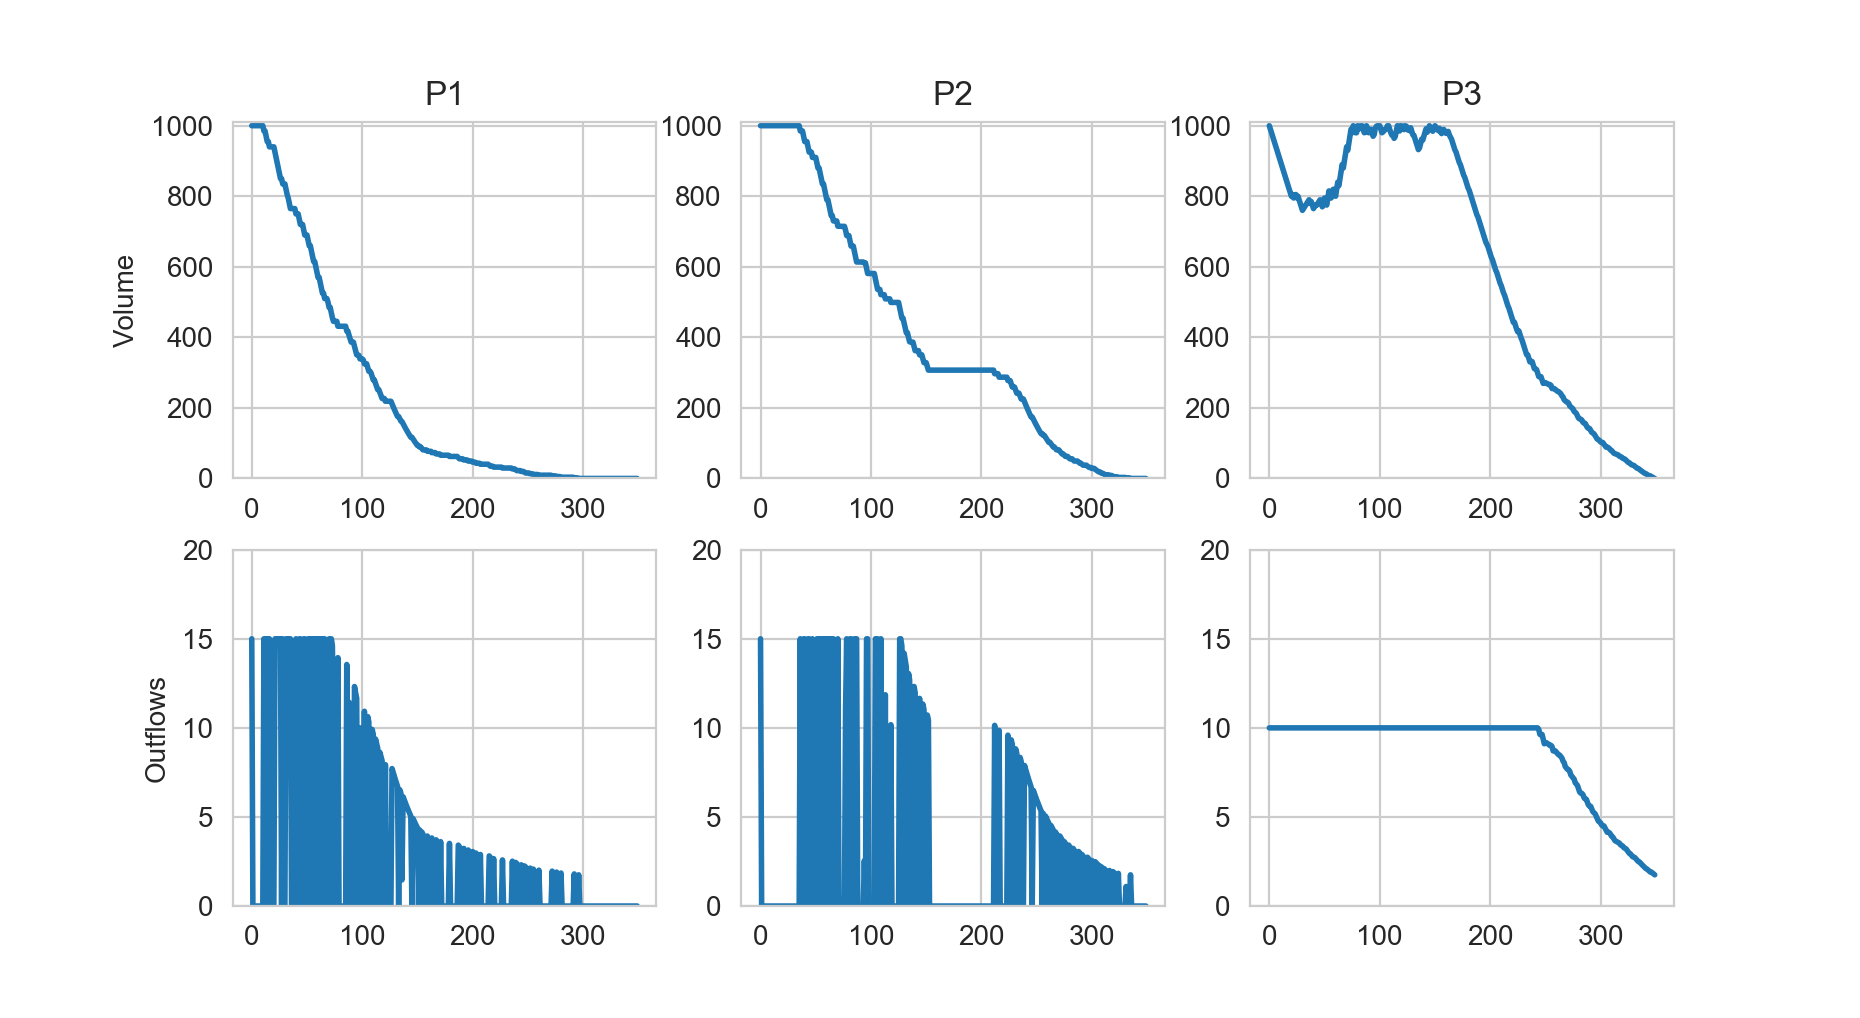

(0, 20)

In [5]:
# Create a model 
m = Model("threeponds_timeoftravel")

# Create intial volume 
InitialVolume = 1000
# Basins beign controlled 
basins = [0, 1, 2]

# Time horizon for solving
horizon = [i for i in range(0,350)]

# Create volumes for each basin 
volumes = m.addVars(horizon, basins, ub=1000, name="volume")

# Create Valves for each basin 
outflows = m.addVars(horizon, basins, name="outflows")


# Create Constraints 
## 1. Max volume capacity constraint already enforced

## 2. Flow limit in channels 
m.addConstrs((outflows[time, 0] <= 15 for time in horizon), name="Upstream Channel1")
m.addConstrs((outflows[time, 1] <= 15 for time in horizon), name="Upstream Channel2")
m.addConstrs((outflows[time, 2] <= 10 for time in horizon), name="Downstream Channel")

## 3. Flow limit based on the volume in the ponds
m.addConstrs((outflows[time, 0] <= (volumes[time-1, 0]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:]), name="Upstream Pond1")
m.addConstrs((outflows[time, 1] <= (volumes[time-1, 1]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:]), name="Upstream Pond2")
m.addConstrs((outflows[time, 2] <= (volumes[time-1, 2]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:]), name="Downstream Pond")

## 4. Add some initial volume 
m.addConstr(volumes[0, 0] == InitialVolume, "Initial Volume Pond 1")
m.addConstr(volumes[0, 1] == InitialVolume, "Initial Volume Pond 2")
m.addConstr(volumes[0, 2] == InitialVolume, "Initial Volume Pond 3")

## 5. Volume constraints 
m.addConstrs((volumes[time, 0]  == volumes[time-1, 0] - outflows[time, 0] for time in horizon[1:]), name="Mass Balance pond:1")
m.addConstrs((volumes[time, 1]  == volumes[time-1, 1] - outflows[time, 1] for time in horizon[1:]), name="Mass Balance pond:2")
m.addConstrs(((volumes[time, 2]  == volumes[time-1, 2] - outflows[time, 2] if time <=10 else volumes[time, 2]  == volumes[time-1, 2] - outflows[time, 2] + outflows[time-10, 0] + outflows[time-10, 1]) for time in horizon[1:]), name="Mass Balance pond:3")

## 5. Minimize the water in the network ponds
m.setObjective(outflows.sum(), GRB.MAXIMIZE)
m.optimize()

# Parse using regex 
data = {}
data["volume_0"] = []
data["volume_1"] = []
data["volume_2"] = []

data["outflows_0"] = []
data["outflows_1"] = []
data["outflows_2"] = []

for v in m.getVars():
    temp = re.split('\[|,|\]', v.varName)
    data[temp[0] + "_" + temp[2]].append(v.x)

plt.subplot(2,3,1)
plt.plot(data["volume_0"], linewidth=2.0)
plt.ylabel("Volume")
plt.ylim([0, InitialVolume+10])
plt.title("P1")

plt.subplot(2,3,2)
plt.plot(data["volume_1"], linewidth=2.0)
plt.ylim([0, InitialVolume+10])
plt.title("P2")

plt.subplot(2,3,3)
plt.plot(data["volume_2"], linewidth=2.0)
plt.ylim([0, InitialVolume+10])
plt.title("P3")

plt.subplot(2,3,4)
plt.plot(data["outflows_0"], linewidth=2.0)
plt.ylim([0, 20])
plt.ylabel("Outflows")

plt.subplot(2,3,5)
plt.plot(data["outflows_1"], linewidth=2.0)
plt.ylim([0, 20])

plt.subplot(2,3,6)
plt.plot(data["outflows_2"], linewidth=2.0)
plt.ylim([0, 20])

### What are problem with centralized control approach and how would you fix them?

There are a lot !, we will speak about them later.

Major issue with the centralized approach is that it results is **lot** of constraints. For example, in the above scenarion with three ponds for a horizon of 350 steps, we have :
1. Mass balance Constraints : 3 $\times$ 350 
2. Flow Constraints : 3 $\times$ 350 

almost 2100 constraints and they linearly increase as the size of the problem increases. 

## Decentralized Control
### Can we do better ?

Ideally, each pond does not need information about the entire system. So we can partition the problem into two problems. A master problem that computes the movement of mass and a set of subproblems that compute the actual actions.

**Notation** 

**Master Problem**

***Objective***
Maximize the routing in Links
$$ \max \sum^N_i V_{ij}^i $$

***Constraints***

**Mass Balance**

$$ V_{ij} \leq T \times u_{ij} $$ 

$$ V_i = V_i^0 + \sum_{j} V_{ji} - \sum_{i} V_{ij} $$

Master problems solves for the amount of mass that can be moved in links and this result is used to constrain the subproblems. 

**Sub Problem**

Maximize the routing in Links
$$ \max \sum^T_t V_{i}^t $$

***Constraints***

**Mass Balance**

$$ x_{ij}^t \leq f(V_{ij}^{t-1}) $$

$$ \sum_t x_{ij}^t \leq V_{ij} $$

$$ V_i^t = V_i^{t-1} + q_{i}^t - \sum_j x_{ij}^t $$ 

### ADD MORE DETAILS

#### Example : Controlling three ponds

![3ponds](./threeponds.png)

In [ ]:
def to_numpy(gurobi_variable):
    temp = [gurobi_variable[i].x for i in gurobi_variable.keys()]
    return np.asarray(temp)

def MasterProblem(horizon=20, init_vol=[1000, 1000, 1000]):
    # Create Model 
    m = Model("MP")

    upper_volume = 1200 # Volume limits.

    basins  = [i for i in range(0, 3)]
    max_threshold  = [10*horizon, 10*horizon, 5*horizon]
    # Create Basin Volume
    volume_basins = m.addVars(basins, lb=0, ub=upper_volume, vtype=GRB.CONTINUOUS, name="Volume_Basin")
    # Create Volume Exchange 
    volume_links  = m.addVars(basins, lb=0, ub=max_threshold, vtype=GRB.CONTINUOUS, name="Volume_Link")
    # Constraints 
    ## 1. Link and basin upper bound constraint set in variable. 
    ## 2. Mass Balance constraint 
    m.addConstr(volume_basins[0] == init_vol[0] - volume_links[0], "P0")
    m.addConstr(volume_basins[1] == init_vol[1] - volume_links[1], "P1")
    m.addConstr(volume_basins[2] == init_vol[2] + volume_links[0] + volume_links[1] - volume_links[2], "P1")
    m.setObjective(volume_basins[0] + volume_basins[1] + volume_basins[2], GRB.MINIMIZE)
    m.optimize()
    return to_numpy(volume_links)

def Subproblem(Volume_Links, init_vol, inflows, horizon_time=20):
    # Common Containers and variables
    obj = GRB.MINIMIZE
    horizon  = [time for time in range(0, horizon_time)]  # Time steps

    # Pond1 -> Generate outflows
    ## Variables 
    m_p1       = Model("Pond1")
    volume_p1  = m_p1.addVars(horizon, lb=0, ub=1200, vtype=GRB.CONTINUOUS, name="Volume")
    outflow_p1 = m_p1.addVars(horizon, lb=0, ub=10 , vtype=GRB.CONTINUOUS, name="Outflows")

    # Constarints 
    m_p1.addConstr(volume_p1[0]      == init_vol[0], "Inital Volume")
    m_p1.addConstr(outflow_p1.sum()  <= Volume_Links[0], "Total Mass Movement")
    m_p1.addConstrs((volume_p1[time] == volume_p1[time-1] - outflow_p1[time-1] for time in horizon[1:]), name="Mass balance")
    m_p1.addConstrs(outflow_p1[time] <= (volume_p1[time-1]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:])

    # Objective 
    m_p1.setObjective(volume_p1.sum(), obj)
    m_p1.optimize()


    # Pond2 -> Generate Outflows 
    ## Variables 
    m_p2       = Model("Pond2")
    volume_p2  = m_p2.addVars(horizon, lb=0, ub=1200, vtype=GRB.CONTINUOUS, name="Volume")
    outflow_p2 = m_p2.addVars(horizon, lb=0, ub=10 , vtype=GRB.CONTINUOUS, name="Outflows")

    # Constarints 
    m_p2.addConstr(volume_p2[0]      == init_vol[1], "Inital Volume")
    m_p2.addConstr(outflow_p2.sum()  <= Volume_Links[1], "Total Mass Movement")
    m_p2.addConstrs((volume_p2[time] == volume_p2[time-1] - outflow_p2[time-1] for time in horizon[1:]), name="Mass balance")
    m_p2.addConstrs(outflow_p2[time] <= (volume_p2[time-1]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:])

    # Objective 
    m_p2.setObjective(volume_p2.sum(), obj)
    m_p2.optimize()


    # Pond3 -> Take in the outflows and plan how you want to release them.
    ## Generate the outflows from the above into the downstream 
    inflow_p1    = to_numpy(outflow_p1)
    inflow_p2    = to_numpy(outflow_p2)
    inflows[10:] = inflows[10:] + inflow_p1[:10] + inflow_p2[:10]  # Travel time inserted here. 

    m_p3       = Model("Pond3")
    volume_p3  = m_p3.addVars(horizon, lb=0, ub=1200, vtype=GRB.CONTINUOUS, name="Volume")
    outflow_p3 = m_p3.addVars(horizon, lb=0, ub=5 , vtype=GRB.CONTINUOUS, name="Outflows")
    # Constarints
    m_p3.addConstr(volume_p3[0]      == init_vol[2] + inflows[0], "Inital Volume")
    m_p3.addConstr(outflow_p3.sum()  <= Volume_Links[2], "Total Mass Movement")
    m_p3.addConstrs((volume_p3[time] == volume_p3[time-1] - outflow_p3[time-1] + inflows[time] for time in horizon[1:]), name="Mass balance")
    m_p3.addConstrs(outflow_p3[time] <= (volume_p3[time-1]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:])

    # Objective 
    m_p3.setObjective(volume_p3.sum(), obj)
    m_p3.optimize()

    data = {}
    data["P1"] = {"volume":to_numpy(volume_p1), "outflow":to_numpy(outflow_p1)}
    data["P2"] = {"volume":to_numpy(volume_p2), "outflow":to_numpy(outflow_p2)}
    data["P3"] = {"volume":to_numpy(volume_p3), "outflow":to_numpy(outflow_p3)}
    return data, inflows

# Create water in the system
INIT_VOLUME = [1000, 1000, 100]
DATA = []
# Iteration 1
volume_links = MasterProblem(20, INIT_VOLUME)
print(volume_links)
inflows = np.zeros(20)
data, inflows = Subproblem(volume_links, INIT_VOLUME, inflows)
DATA.append(data)
for t in range(0,50):
    print("-----------------------------", t)
    INIT_VOLUME = [data["P1"]["volume"][10], data["P2"]["volume"][10], data["P3"]["volume"][10]]
    volume_links = MasterProblem(20, INIT_VOLUME)
    data, inflows = Subproblem(volume_links, INIT_VOLUME, inflows)
    DATA.append(data)
    
    temp = copy.deepcopy(inflows[10:])
    inflows = np.zeros(20)
    inflows[:10] = temp
    
# Stack the things
volume_1 = DATA[0]["P1"]["volume"][:10]
for i in range(1, len(DATA)):
    volume_1 = np.append(volume_1, DATA[i]["P1"]["volume"][:10])
    
volume_2 = DATA[0]["P2"]["volume"][:10]
for i in range(1, len(DATA)):
    volume_2 = np.append(volume_2, DATA[i]["P2"]["volume"][:10])
    
volume_3= DATA[0]["P3"]["volume"][:10]
for i in range(1, len(DATA)):
    volume_3 = np.append(volume_3, DATA[i]["P3"]["volume"][:10])

outflow_1 = DATA[0]["P1"]["outflow"][:10]
for i in range(1, len(DATA)):
    outflow_1 = np.append(outflow_1, DATA[i]["P1"]["outflow"][:10])
    
outflow_2 = DATA[0]["P2"]["outflow"][:10]
for i in range(1, len(DATA)):
    outflow_2 = np.append(outflow_2, DATA[i]["P2"]["outflow"][:10])
    
outflow_3= DATA[0]["P3"]["outflow"][:10]
for i in range(1, len(DATA)):
    outflow_3 = np.append(outflow_3, DATA[i]["P3"]["outflow"][:10])

<IPython.core.display.Javascript object>


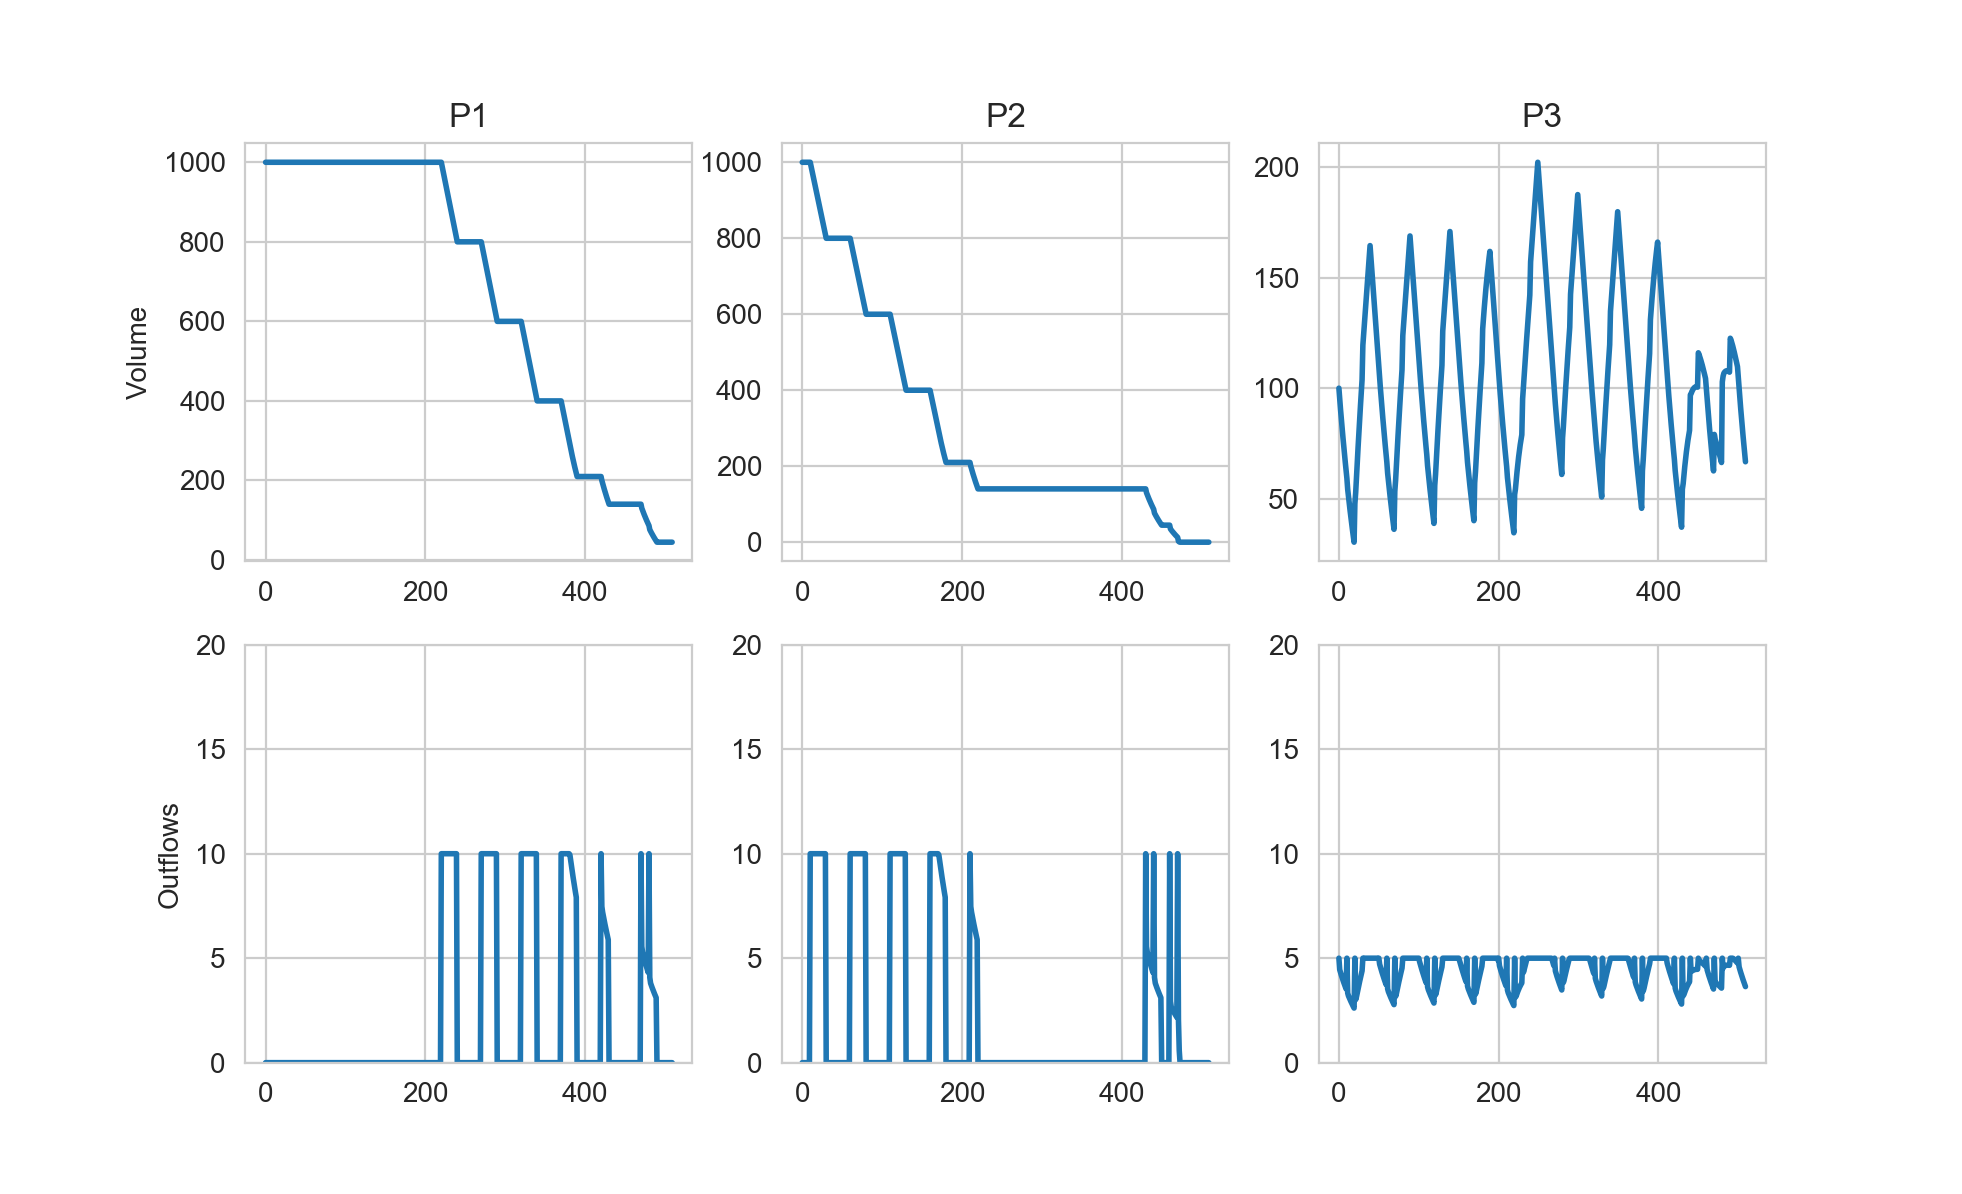

(0, 20)

In [55]:
plt.subplot(2,3,1)
plt.plot(volume_1, linewidth=2.0)
plt.ylabel("Volume")
plt.title("P1")

plt.subplot(2,3,2)
plt.plot(volume_2, linewidth=2.0)
plt.title("P2")

plt.subplot(2,3,3)
plt.plot(volume_3, linewidth=2.0)
plt.title("P3")

plt.subplot(2,3,4)
plt.plot(outflow_1, linewidth=2.0)
plt.ylim([0, 20])
plt.ylabel("Outflows")

plt.subplot(2,3,5)
plt.plot(outflow_2, linewidth=2.0)
plt.ylim([0, 20])

plt.subplot(2,3,6)
plt.plot(outflow_3, linewidth=2.0)
plt.ylim([0, 20])

## How would just control achive this objective ?

In [ ]:
CHANNEL_FLOW = 10

def to_numpy(gurobi_variable):
    temp = [gurobi_variable[i].x for i in gurobi_variable.keys()]
    return np.asarray(temp)

def MasterProblem(horizon=20, init_vol=[1000, 1000, 1000]):
    # Create Model 
    m = Model("MP")
    link_up = horizon*CHANNEL_FLOW
    upper_volume = 1000 # Volume limits.

    basins  = [i for i in range(0, 3)]

    # Create Basin Volume
    volume_basins = m.addVars(basins, lb=0, ub=upper_volume, vtype=GRB.CONTINUOUS, name="Volume_Basin")
    # Create Volume Exchange 
    volume_links  = m.addVars(basins, lb=0, ub=link_up, vtype=GRB.CONTINUOUS, name="Volume_Link")
    # Constraints 
    ## 1. Link and basin upper bound constraint set in variable. 
    ## 2. Mass Balance constraint 
    m.addConstr(volume_basins[0] == init_vol[0] - volume_links[0], "P0")
    m.addConstr(volume_basins[1] == init_vol[1] - volume_links[1], "P1")
    m.addConstr(volume_basins[2] == init_vol[2] + volume_links[0] + volume_links[1] - volume_links[2], "P1")
    m.setObjective(volume_basins.sum(), GRB.MINIMIZE)
    m.optimize()
    return to_numpy(volume_links)

def Subproblem(Volume_Links, init_vol, inflows, horizon_time=20):
    # Common Containers and variables 
    horizon  = [time for time in range(0, horizon_time)]  # Time steps

    # Pond1 -> Generate outflows
    ## Variables 
    m_p1       = Model("Pond1")
    volume_p1  = m_p1.addVars(horizon, lb=0, ub=1200, vtype=GRB.CONTINUOUS, name="Volume")
    outflow_p1 = m_p1.addVars(horizon, lb=0, ub=CHANNEL_FLOW , vtype=GRB.CONTINUOUS, name="Outflows")

    # Constarints 
    m_p1.addConstr(volume_p1[0]      == init_vol[0], "Inital Volume")
    #m_p1.addConstr(outflow_p1.sum()  <= Volume_Links[0], "Total Mass Movement")
    m_p1.addConstrs((volume_p1[time] == volume_p1[time-1] - outflow_p1[time-1] for time in horizon[1:]), name="Mass balance")
    m_p1.addConstrs(outflow_p1[time] <= (volume_p1[time-1]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:])

    # Objective 
    m_p1.setObjective(outflow_p1.sum(), GRB.MAXIMIZE)
    m_p1.optimize()


    # Pond2 -> Generate Outflows 
    ## Variables 
    m_p2       = Model("Pond2")
    volume_p2  = m_p2.addVars(horizon, lb=0, ub=1200, vtype=GRB.CONTINUOUS, name="Volume")
    outflow_p2 = m_p2.addVars(horizon, lb=0, ub=CHANNEL_FLOW , vtype=GRB.CONTINUOUS, name="Outflows")

    # Constarints 
    m_p2.addConstr(volume_p2[0]      == init_vol[1], "Inital Volume")
    #m_p2.addConstr(outflow_p2.sum()  <= Volume_Links[1], "Total Mass Movement")
    m_p2.addConstrs((volume_p2[time] == volume_p2[time-1] - outflow_p2[time-1] for time in horizon[1:]), name="Mass balance")
    m_p2.addConstrs(outflow_p2[time] <= (volume_p2[time-1]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:])

    # Objective 
    m_p2.setObjective(outflow_p2.sum(), GRB.MAXIMIZE)
    m_p2.optimize()


    # Pond3 -> Take in the outflows and plan how you want to release them.
    ## Generate the outflows from the above into the downstream 
    inflow_p1    = to_numpy(outflow_p1)
    inflow_p2    = to_numpy(outflow_p2)
    inflows[10:] = inflows[10:] + inflow_p1[:10] + inflow_p2[:10]  # Travel time inserted here. 

    m_p3       = Model("Pond3")
    volume_p3  = m_p3.addVars(horizon, lb=0, ub=2000, vtype=GRB.CONTINUOUS, name="Volume")
    outflow_p3 = m_p3.addVars(horizon, lb=0, ub=5 , vtype=GRB.CONTINUOUS, name="Outflows")
    # Constarints
    m_p3.addConstr(volume_p3[0]      == init_vol[2] + inflows[0], "Inital Volume")
    #m_p3.addConstr(outflow_p3.sum()  <= Volume_Links[2], "Total Mass Movement")
    m_p3.addConstrs((volume_p3[time] == volume_p3[time-1] - outflow_p3[time-1] + inflows[time] for time in horizon[1:]), name="Mass balance")
    m_p3.addConstrs(outflow_p3[time] <= (volume_p3[time-1]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:])

    # Objective 
    m_p3.setObjective(outflow_p3.sum(), GRB.MAXIMIZE)
    m_p3.optimize()

    data = {}
    data["P1"] = {"volume":to_numpy(volume_p1), "outflow":to_numpy(outflow_p1)}
    data["P2"] = {"volume":to_numpy(volume_p2), "outflow":to_numpy(outflow_p2)}
    data["P3"] = {"volume":to_numpy(volume_p3), "outflow":to_numpy(outflow_p3)}
    return data, inflows


# Create water in the system
INIT_VOLUME = [1000, 1000, 100]

DATA = []
volume_links = []
# Iteration 1
inflows = np.zeros(20)
data, inflows = Subproblem(volume_links, INIT_VOLUME, inflows)
DATA.append(data)
for t in range(0,50):
    print("-----------------------------", t)
    INIT_VOLUME = [data["P1"]["volume"][10], data["P2"]["volume"][10], data["P3"]["volume"][10]]
    data, inflows = Subproblem(volume_links, INIT_VOLUME, inflows)
    DATA.append(data)
    temp = copy.deepcopy(inflows[10:])
    inflows = np.zeros(20)
    inflows[:10] = temp

# Stack the things
volume_1 = DATA[0]["P1"]["volume"][10:]
for i in range(1, len(DATA)):
    volume_1 = np.append(volume_1, DATA[i]["P1"]["volume"][10:])
    
volume_2 = DATA[0]["P2"]["volume"][10:]
for i in range(1, len(DATA)):
    volume_2 = np.append(volume_2, DATA[i]["P2"]["volume"][10:])
    
volume_3= DATA[0]["P3"]["volume"][10:]
for i in range(1, len(DATA)):
    volume_3 = np.append(volume_3, DATA[i]["P3"]["volume"][10:])

outflow_1 = DATA[0]["P1"]["outflow"][10:]
for i in range(1, len(DATA)):
    outflow_1 = np.append(outflow_1, DATA[i]["P1"]["outflow"][10:])
    
outflow_2 = DATA[0]["P2"]["outflow"][10:]
for i in range(1, len(DATA)):
    outflow_2 = np.append(outflow_2, DATA[i]["P2"]["outflow"][10:])
    
outflow_3= DATA[0]["P3"]["outflow"][10:]
for i in range(1, len(DATA)):
    outflow_3 = np.append(outflow_3, DATA[i]["P3"]["outflow"][10:])



<IPython.core.display.Javascript object>


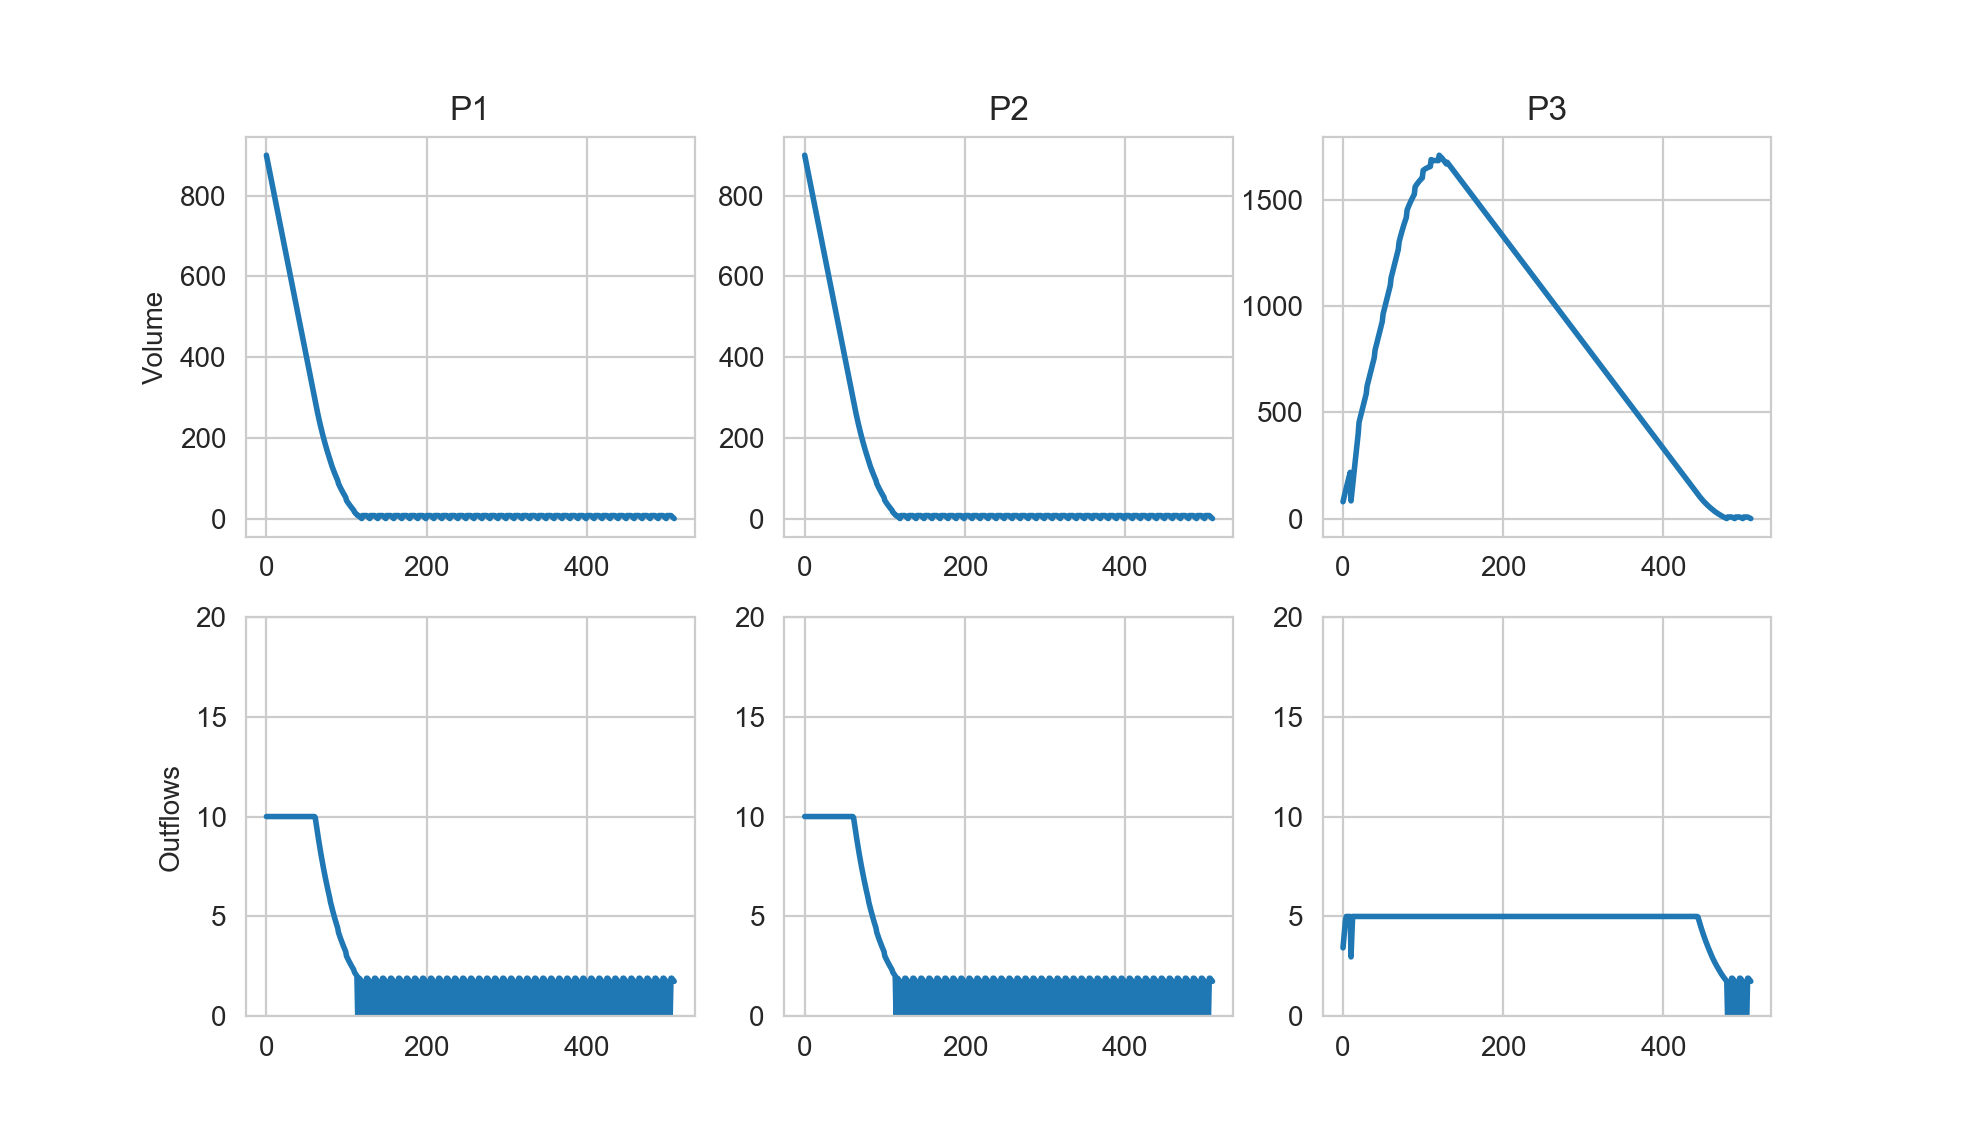

(0, 20)

In [58]:
plt.subplot(2,3,1)
plt.plot(volume_1, linewidth=2.0)
plt.ylabel("Volume")
plt.title("P1")

plt.subplot(2,3,2)
plt.plot(volume_2, linewidth=2.0)
plt.title("P2")

plt.subplot(2,3,3)
plt.plot(volume_3, linewidth=2.0)
plt.title("P3")

plt.subplot(2,3,4)
plt.plot(outflow_1, linewidth=2.0)
plt.ylim([0, 20])
plt.ylabel("Outflows")

plt.subplot(2,3,5)
plt.plot(outflow_2, linewidth=2.0)
plt.ylim([0, 20])

plt.subplot(2,3,6)
plt.plot(outflow_3, linewidth=2.0)
plt.ylim([0, 20])